In [28]:
from pymonntorch import (
    NeuronGroup, SynapseGroup, 
    NeuronDimension, Recorder, Behavior,
    EventRecorder,
)
from conex import (
    Neocortex,
    prioritize_behaviors,
)

from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    LIF,
    SpikeTrace,
    NeuronAxon,
    Fire,
    KWTA,
)

from conex.behaviors.neurons.homeostasis import (
    VoltageBaseHomeostasis,
    ActivityBaseHomeostasis,
)

from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    SimpleDendriticInput,
    SimpleSTDP,
    Conv2dDendriticInput,
    Conv2dSTDP,
    LateralDendriticInput,
    WeightClip,
)

import torch, random, os, sys, time, math
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson

In [29]:
def genPatterns(N : int, T : int, C : int, I : int) -> tuple:
    pattern0 = [[0 for _ in range(2*N)] for _ in range(T)]
    pattern1 = [([(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N + I)] + [0]*(N - I)) for i in range(T)] 
    pattern2 = [([0]*(N - I) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N + I)]) for i in range(T)]
    return pattern0, pattern1, pattern2

# def genPatterns(N : int, T : int, C : int) -> tuple:
#     pattern0 = [[0 for _ in range(5*N)] for _ in range(T)]
#     pattern1 = [([(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(4*N)) for i in range(T)]
#     pattern2 = [([0]*(N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(3*N)) for i in range(T)]
#     pattern3 = [([0]*(2*N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(2*N)) for i in range(T)]
#     pattern4 = [([0]*(3*N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(N)) for i in range(T)]
#     pattern5 = [([0]*(4*N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)]) for i in range(T)]
#     return pattern0, pattern1, pattern2, pattern3, pattern4, pattern5

I = 0
pattern0, pattern1, pattern2 = genPatterns(N = 8, T = 15, C = 5, I = I)

In [30]:
class ForcedLIF(LIF):
    def __init__(self, R, threshold, tau, v_reset, v_rest, *args, init_v=None, init_s=None, **kwargs):
        super().__init__(R, threshold, tau, v_reset, v_rest, *args, init_v=init_v, init_s=init_s, **kwargs)
    
    def initialize(self, neurons : NeuronGroup) -> None:
        """_summary_

        Args:
            neurons (NeuronGroup): _description_

        Raises:
            ValueError: _description_
        """
        super().initialize(neurons)
        self.params = self.parameter("params", default = None)
        

        
        if self.params is None: raise ValueError("params is not set")
        for k, v in self.params.items():
            setattr(self, k, v)
            
        neurons.spikes = neurons.vector(mode = 0)
        self.TI = min(self.TI, self.T)
            
        T, N, C, I = self.T, self.N, self.C, self.I
        self.pattern0 = [[0 for _ in range(2*N)] for _ in range(T)]
        self.pattern1 = [([(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N + I)] + [0]*(N - I)) for i in range(T)] 
        self.pattern2 = [([0]*(N - I) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N + I)]) for i in range(T)]
    
        
        # self.pattern0 = [[0 for _ in range(5*N)] for _ in range(T)]
        # self.pattern1 = [([(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(4*N)) for i in range(T)]
        # self.pattern2 = [([0]*(N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(3*N)) for i in range(T)]
        # self.pattern3 = [([0]*(2*N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(2*N)) for i in range(T)]
        # self.pattern4 = [([0]*(3*N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)] + [0]*(N)) for i in range(T)]
        # self.pattern5 = [([0]*(4*N) + [(1 if random.uniform(0,1) <= poisson.pmf(k = i, mu = T/2)*C else 0) for _ in range(N)]) for i in range(T)]
        
        
        # self.pattern0, self.pattern1, self.pattern2 = pattern0, pattern1, pattern2
        
    def whichPattern(self, iter : int) -> torch.tensor:
        if   ((iter // self.TW) % 4 == 0):  return torch.tensor(self.pattern1[iter % self.TI], dtype=torch.float32)
        elif ((iter // self.TW) % 4 == 1):  return torch.tensor(self.pattern0[iter % self.TI], dtype=torch.float32)
        elif ((iter // self.TW) % 4 == 2):  return torch.tensor(self.pattern2[iter % self.TI], dtype=torch.float32)
        else:                               return torch.tensor(self.pattern0[iter % self.TI], dtype=torch.float32) 
        
        # if   ((iter // self.TW) % 10 % 2 == 0):  return torch.tensor(self.pattern0[iter % self.TI], dtype=torch.float32)
        # elif ((iter // self.TW) % 10 == 1):      return torch.tensor(self.pattern1[iter % self.TI], dtype=torch.float32)
        # elif ((iter // self.TW) % 10 == 3):      return torch.tensor(self.pattern2[iter % self.TI], dtype=torch.float32)
        # elif ((iter // self.TW) % 10 == 5):      return torch.tensor(self.pattern3[iter % self.TI], dtype=torch.float32)
        # elif ((iter // self.TW) % 10 == 7):      return torch.tensor(self.pattern4[iter % self.TI], dtype=torch.float32)
        # else:                                    return torch.tensor(self.pattern5[iter % self.TI], dtype=torch.float32)
        
    def forward(self, neurons : NeuronGroup) -> None:
        neurons.v = self.whichPattern(neurons.iteration)  

2000xBatch: 1/1 (100%) 2870.348ms


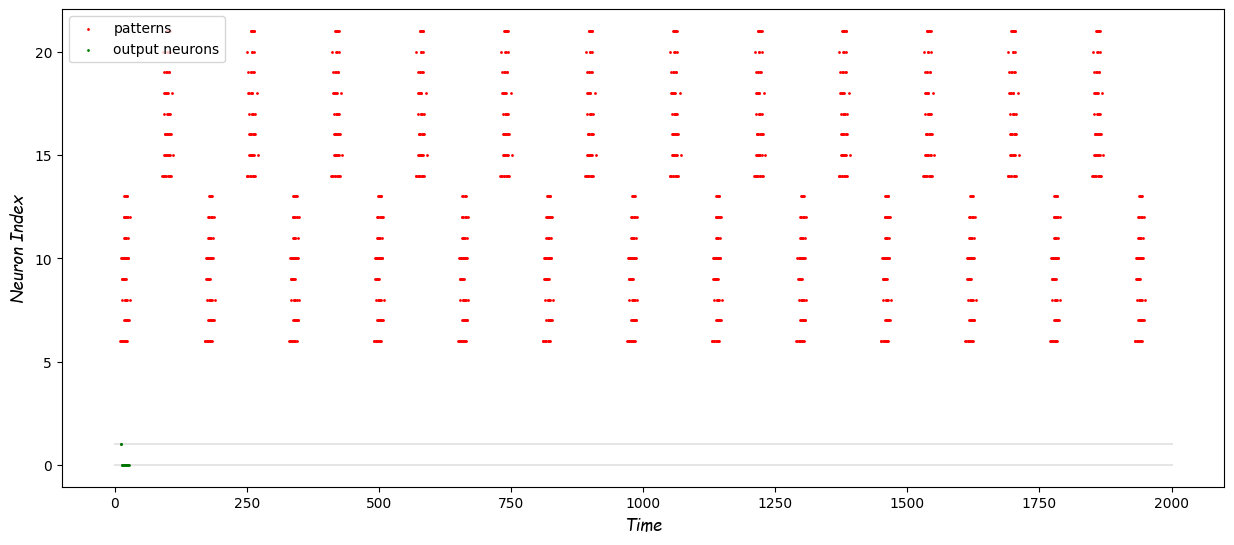

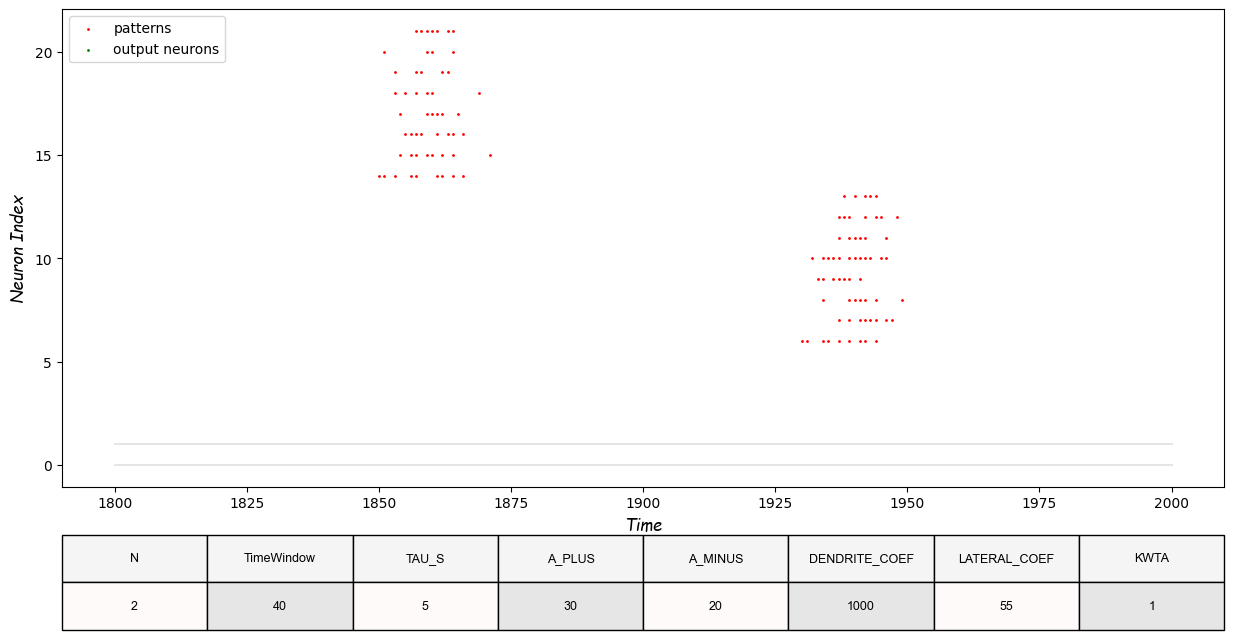

In [31]:
DEVICE = "cpu"
DTYPE = torch.float32
DT = 0.1
TAU_S = 5
A_PLUS = 30
A_MINUS = 20
K = 1

PAT = 2
PRE_SIZE = 16
PST_SIZE = 2

DENDRITE_COEF = 1000
LATERAL_DENDRITE_COEF = 55

PRE_DIMN = NeuronDimension(depth = 1, height = 1, width = 2*PRE_SIZE-1)
PST_DIMN = NeuronDimension(depth = 1, height = 1, width = 2*PST_SIZE-1)

T = 40
FORCED_PARAMS = { "T" : T,  "C" : 7,  "I" : 0,  "TW" : T,  "TI" : T, "N" : PRE_SIZE // PAT }

PRE_PARAMS = { "R" : 0,             "threshold" : 0.5,        "tau" : 0,        "v_reset" : 0,       "v_rest" : 0,       "init_v" : 0 }
PST_PARAMS = { "R" : 5,             "threshold" : -66,        "tau" : 10,       "v_reset" : -68,     "v_rest" : -67,     "init_v" : "normal(-68, 3)" }

network = Neocortex(dt=DT, device=DEVICE, dtype=DTYPE)

PRE_BEHAVIOR = prioritize_behaviors([
    ForcedLIF(
                    R = PRE_PARAMS["R"],
                    threshold = PRE_PARAMS["threshold"],
                    tau = PRE_PARAMS["tau"],
                    v_reset = PRE_PARAMS["v_reset"],
                    v_rest = PRE_PARAMS["v_rest"],
                    init_v = PRE_PARAMS["init_v"],
                    params = FORCED_PARAMS
        ),
    SpikeTrace(tau_s = TAU_S),
    NeuronAxon(),
    Fire(),
    Recorder(tag = "PRE_RECORDER", variables = ["v"]),
    EventRecorder(tag = "PRE_EVENT_RECORDER", variables = ["spikes"]),
]); pre_population = NeuronGroup(net = network, size = PRE_SIZE, behavior = PRE_BEHAVIOR)

PST_BEHAVIOR = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    LIF(
                    R = PST_PARAMS["R"],
                    threshold = PST_PARAMS["threshold"],
                    tau = PST_PARAMS["tau"],
                    v_reset = PST_PARAMS["v_reset"],
                    v_rest = PST_PARAMS["v_rest"],
                    init_v = PST_PARAMS["init_v"],
        ),
    SpikeTrace(tau_s = TAU_S),
    NeuronAxon(),
    Fire(),
    KWTA(k = K),
    # VoltageBaseHomeostasis(),
    # ActivityBaseHomeostasis(window_size = 150, activity_rate = 10, updating_rate = 1, decay_rate = 0.85), ://////////
    Recorder(tag = "PST_RECORDER", variables = ["v", "I"]),
    EventRecorder(tag = "PST_EVENT_RECORDER", variables = ["spikes"]),
]); pst_population = NeuronGroup(net = network, size = PST_SIZE, behavior = PST_BEHAVIOR)

SYN_BEHAVIOR = prioritize_behaviors([
    SynapseInit(),
    WeightInitializer(mode = "normal(2, 0.2)"),
    SimpleDendriticInput(current_coef = DENDRITE_COEF),
    SimpleSTDP(a_plus = A_PLUS, a_minus = A_MINUS),
    WeightClip(w_max = 10, w_min = 0),
    Recorder(tag = "SYN_RECORDER", variables = ["weights", "I"]),
]); synapse = SynapseGroup(net = network, src = pre_population, dst = pst_population, behavior = SYN_BEHAVIOR, tag = "Proximal")


LATERAL_BEHAVIOR = prioritize_behaviors([
    SynapseInit(),
    # WeightInitializer(weights = torch.Tensor([1, 0, 1]).view(1, 1, 1, 1, 3)),
    WeightInitializer(weights = torch.Tensor([1, 0, 1, 0, 1, 0, 1, 0, 1]).view(1, 1, 1, 1, 9)),
    LateralDendriticInput(inhibitory = True, current_coef = LATERAL_DENDRITE_COEF),
    Recorder(tag = "LATERAL_SYN_RECORDER", variables = ["weights", "I"]),
]); 
lateral = SynapseGroup(net = network, src = pst_population, dst = pst_population, behavior = LATERAL_BEHAVIOR, tag = "Proximal, inh")

ITERATIONS = 2000
network.initialize(False)
network.simulate_iterations(ITERATIONS)

def FIGS():
    global network
    PRE_SPIKES = network["PRE_EVENT_RECORDER", 0]["spikes", 0][:, 1]
    PRE_TIME = network["PRE_EVENT_RECORDER", 0]["spikes", 0][:, 0]
    
    PST_SPIKES = network["PST_EVENT_RECORDER", 0]["spikes", 0][:, 1]
    PST_TIME = network["PST_EVENT_RECORDER", 0]["spikes", 0][:, 0]
    
    # plot size
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(15, 6.2)
    plt.scatter(PRE_TIME, PRE_SPIKES + 6, s = 1, c = "red",   label = "patterns")
    plt.scatter(PST_TIME, PST_SPIKES,     s = 1, c = "green", label = "output neurons")
    plt.xlabel("Time", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
    plt.ylabel("Neuron Index", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
    plt.legend(loc = "upper left")
    for i in range(PST_SIZE):
        plt.plot([0, ITERATIONS], [i, i], color = "black", alpha = 0.1)
    plt.show()
    
    ZOOM = 1800
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(15, 6.2)
    ax.scatter(PRE_TIME[PRE_TIME > ZOOM], PRE_SPIKES[PRE_TIME > ZOOM] + 6, s = 1, c = "red",   label = "patterns")
    ax.scatter(PST_TIME[PST_TIME > ZOOM], PST_SPIKES[PST_TIME > ZOOM],     s = 1, c = "green", label = "output neurons")
    ax.set_xlabel("Time", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
    ax.set_ylabel("Neuron Index", fontsize = 12, style = "italic", color = "black", fontname = "Comic Sans MS")
    ax.legend(loc = "upper left")
    
    POST_COLORS = ["red", "green"]
    for i in range(PST_SIZE):
        ax.plot([ZOOM, ITERATIONS], [i, i], color = "black", alpha = 0.1)
    
    FONT = "arial"
    parameters = ["N", "TimeWindow", "TAU_S", "A_PLUS", "A_MINUS", "DENDRITE_COEF", "LATERAL_COEF", "KWTA"]
    values = [PST_SIZE, FORCED_PARAMS["TW"], TAU_S, A_PLUS, A_MINUS, DENDRITE_COEF, LATERAL_DENDRITE_COEF, K]
    table_data = [parameters, values]
    table = plt.table(cellText = table_data, cellLoc = "center", loc = "bottom", bbox = [0, -0.3, 1, 0.2])
    table.scale(0.8, 0.8)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    for i in range(len(parameters)):
        table[(0, i)].set_facecolor("whitesmoke")
        table[(0, i)].set_text_props(color = 'black', fontfamily = FONT)

    for i in range(len(values)):
        table[(1, i)].set_facecolor("snow" if i % 2 == 0 else '#e6e6e6')
        table[(1, i)].set_text_props(fontfamily = FONT)
            
    plt.show()
    
    
FIGS()